In [1]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [2]:
import torch
torch.cuda.set_device(2)

In [3]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [4]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [5]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=16)

In [6]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnet50')
]

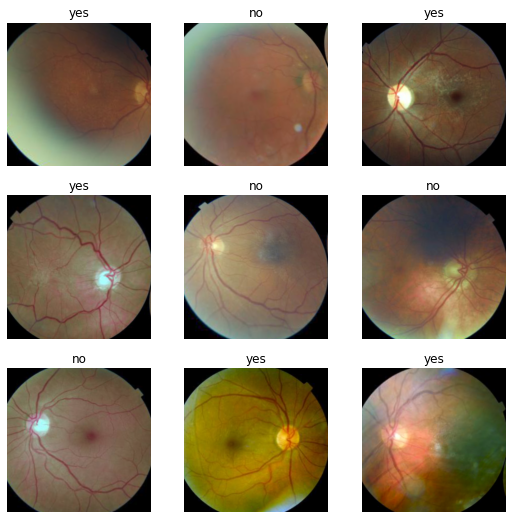

In [7]:
dls512.show_batch()

In [8]:
learn = cnn_learner(dls512,resnet50,cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=2.511886486900039e-05)

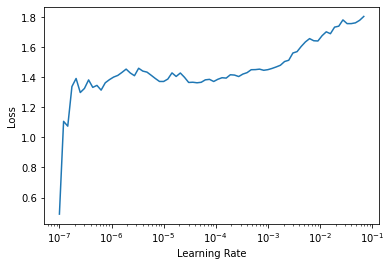

In [9]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.282862,0.811896,0.602446,0.611538,0.500000,00:16


Better model found at epoch 0 with valid_loss value: 0.8118960857391357.


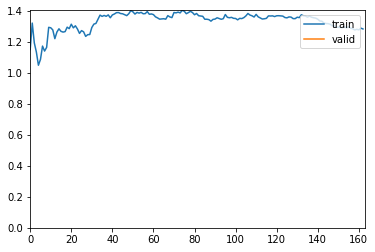

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.185833,0.785436,0.596330,0.596429,0.525157,00:19
1,1.148756,0.784500,0.591743,0.591398,0.518868,00:19
2,1.130315,0.757621,0.599388,0.584337,0.610063,00:19
3,1.112111,0.759308,0.585627,0.568915,0.610063,00:19
4,1.067094,0.735279,0.631498,0.625407,0.603774,00:19
5,1.076014,0.758014,0.614679,0.618705,0.540881,00:19
6,1.088290,0.753582,0.628440,0.613982,0.635220,00:19
7,1.006683,0.757127,0.636086,0.661290,0.515723,00:19


Better model found at epoch 0 with valid_loss value: 0.7854361534118652.


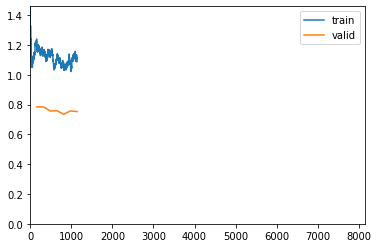

Better model found at epoch 1 with valid_loss value: 0.7845004200935364.
Better model found at epoch 2 with valid_loss value: 0.7576211094856262.
Better model found at epoch 4 with valid_loss value: 0.7352787852287292.
No improvement since epoch 4: early stopping


In [10]:
learn.fine_tune(50,base_lr=1e-4)

In [11]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

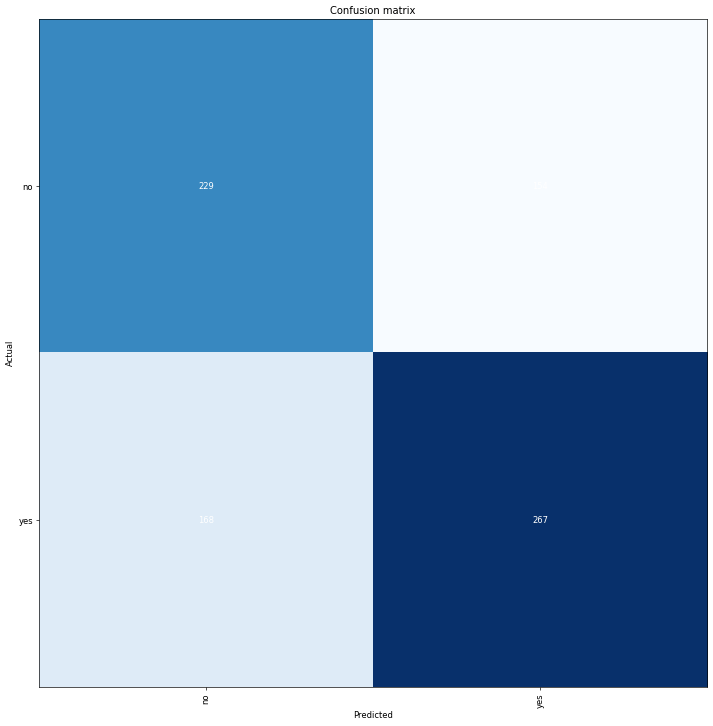

In [12]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [13]:
learn.cbs=[]

In [16]:
learn.validate()


AttributeError: 'list' object has no attribute 'sorted'

In [17]:
learn.export(fname='resnet50.pkl')